<a href="https://colab.research.google.com/github/onlygoodman/Python_practice/blob/master/DL_powerflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# N = 3, N: number of bus

import pandas as pd
from keras import models
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
import matplotlib.pyplot as plt


class Powerflow:
    """The power flow class is a class for finding voltage and phase through deep learning using P and Q about Nbus. """

    def __init__(self, N):
        
        self.N = N

    # load data function
    def load_data(self, path = './flowdata/DLdata/'):
        """
        load data function

        Args : 
            N(int) is number of bus

            path(str) default path is './flowdata/DLdata/'

        Returns : 
            [P_Lpu, Q_Lpu, V_list, del_list] type is DataFrame
        """

        P_Lpu, Q_Lpu, V_list, del_list = 0, 0, 0, 0
        data_list = [P_Lpu, Q_Lpu, V_list, del_list]
        value_name = ['P_Lpu', 'Q_Lpu', 'V_list', 'del_list']

        for i in range(4):
            data_list[i] = pd.read_csv(path + '{}{:0>3}.csv'.format(value_name[i], self.N))
        
        data_list[2] = data_list[2].transpose()
        data_list[3] = data_list[3].transpose()

        for i in range(2):
            data_list[i] = data_list[i].drop('0', axis = 1)
        
        for i in range(2, 4):
            data_list[i]  = data_list[i].drop(0, axis = 1)
        
        self.P_Lpu, self.Q_Lpu, self.V_list, self.del_list = data_list

        return self.P_Lpu, self.Q_Lpu, self.V_list, self.del_list

    def prepare_data(self, check=False):
        """
        prepare data function

        Args : 
            N(int) is number of bus

        Returns : 
            self.dataV = [train1, val1, test1, train_targets1, val_targets1, test_targets1]

            self.dataD = [train2, val2, test2, train_targets2, val_targets2, test_targets2]
        """

        # 데이터셋 생성
        P_data = np.array(self.P_Lpu)
        Q_data = np.array(self.Q_Lpu)
        V_data = np.array(self.V_list)
        D_data = np.array(self.del_list)

        train_data = np.concatenate((P_data, Q_data), axis = 1)
        train1, test1, train_targets1, test_targets1 = train_test_split(train_data, V_data, 
                                                                            test_size=0.2, 
                                                                            shuffle=True,  
                                                                            random_state=42)
        train1, val1, train_targets1, val_targets1 = train_test_split(train1, train_targets1, 
                                                                            test_size=0.25, 
                                                                            shuffle=True,  
                                                                            random_state=42)

        train2, test2, train_targets2, test_targets2 = train_test_split(train_data, V_data, 
                                                                            test_size=0.2, 
                                                                            shuffle=True,  
                                                                            random_state=42)
        train2, val2, train_targets2, val_targets2 = train_test_split(train2, train_targets2, 
                                                                            test_size=0.25, 
                                                                            shuffle=True,  
                                                                            random_state=42)
        
        self.dataV = [train1, val1, test1, train_targets1, val_targets1, test_targets1]
        self.dataD = [train2, val2, test2, train_targets2, val_targets2, test_targets2]


        print("now model has {} bus".format(self.N))

        if check == True:
            print("traindata shape:", train1.shape)
            print("targetdata shape:", val_targets1.shape)

        return self.dataV, self.dataD


    def build_model(self, n=3, check = False):
        """
        build model function

        Args : 
            N(int) is number of bus

        Returns : 
            self.dataV = [train1, val1, test1, train_targets1, val_targets1, test_targets1]

            self.dataD = [train2, val2, test2, train_targets2, val_targets2, test_targets2]
        """

        input_shape = (len(self.P_Lpu), (self.N-1)*2)
        
        start = 2**(n+5)

        model = models.Sequential()
        model.add(layers.Dense(start, activation='relu', input_shape=(input_shape[1],)))
        model.add(layers.Dropout(0.5))

        for number in range(1, n+1, 2):
            model.add(layers.Dense(start // (2 ** number), activation='relu'))
            model.add(layers.Dropout(0.5))
        
        model.add(layers.Dense(self.N * 2, activation='relu'))
        model.add(layers.Dense(self.N -1))
        model.compile(optimizer='adam', loss='mse', metrics=['mse'])

        self.model = model
        
        if check:    
            model.summary()

        return model

    def fit_model(self, type, epochs=30, batch_size = 64, verbose = 1):
        
        """
        type means v or Theta
        The model type should be determined based on voltage and phase prediction.

        if type V means V

        elif type D means Theta
        
        Args :
            epochs(int) = 30
            N(int): number of bus
            batch_size = 64
            verbose = 1

        Returns :
            mae_history about validation mae
        """

        if type == 'V':
            train, val = self.dataV[0], self.dataV[1]
            train_targets, val_targets = self.dataV[3], self.dataV[4]

        elif type == 'D':
            train, val = self.dataD[0], self.dataD[1]
            train_targets, val_targets = self.dataD[3], self.dataD[4]

        history = self.model.fit(train, train_targets,  
                epochs = epochs, batch_size = batch_size, validation_data=(val, val_targets), verbose=verbose)

        self.mae_history = history.history['mse']
        self.valmae_history = history.history['val_mse']

        return self.mae_history, self.valmae_history


In [ ]:
from tqdm import tqdm

mae_list = []

n = 5
bus = 33
interval = 6
epochs = 50
verbose = 0


# n의 의미는 build model 당시 층의 개수, 복잡도를 의미

for i in tqdm(range(1, n + 1)):
    # for i in range(3, 33 + 1, 6):
    for j in range(3, bus + 1, 3):
        my_powerflow = Powerflow(j)
        my_powerflow.load_data()
        my_powerflow.prepare_data()
        my_powerflow.build_model(n = i, check = False )
        V = my_powerflow.fit_model('V', epochs = epochs, verbose = verbose)

        my_powerflow.build_model()
        D = my_powerflow.fit_model('D', epochs = epochs, verbose = verbose)

        mae_list.append([i, V, D])

  0%|          | 0/5 [00:00<?, ?it/s]

now model has 3 bus
now model has 6 bus
now model has 9 bus
now model has 12 bus
now model has 15 bus
now model has 18 bus
now model has 21 bus
now model has 24 bus
now model has 27 bus
now model has 30 bus
now model has 33 bus


 20%|██        | 1/5 [04:31<18:05, 271.49s/it]

now model has 3 bus
now model has 6 bus
now model has 9 bus
now model has 12 bus
now model has 15 bus
now model has 18 bus
now model has 21 bus
now model has 24 bus
now model has 27 bus
now model has 30 bus
now model has 33 bus


 40%|████      | 2/5 [09:29<14:21, 287.19s/it]

now model has 3 bus
now model has 6 bus
now model has 9 bus
now model has 12 bus
now model has 15 bus
now model has 18 bus
now model has 21 bus
now model has 24 bus
now model has 27 bus
now model has 30 bus
now model has 33 bus


 60%|██████    | 3/5 [15:11<10:24, 312.32s/it]

now model has 3 bus
now model has 6 bus
now model has 9 bus
now model has 12 bus
now model has 15 bus
now model has 18 bus
now model has 21 bus
now model has 24 bus
now model has 27 bus
now model has 30 bus
now model has 33 bus


 80%|████████  | 4/5 [22:05<05:52, 352.40s/it]

now model has 3 bus
now model has 6 bus
now model has 9 bus
now model has 12 bus
now model has 15 bus
now model has 18 bus
now model has 21 bus
now model has 24 bus
now model has 27 bus
now model has 30 bus
now model has 33 bus


100%|██████████| 5/5 [33:37<00:00, 403.50s/it]


IndexError: list index out of range

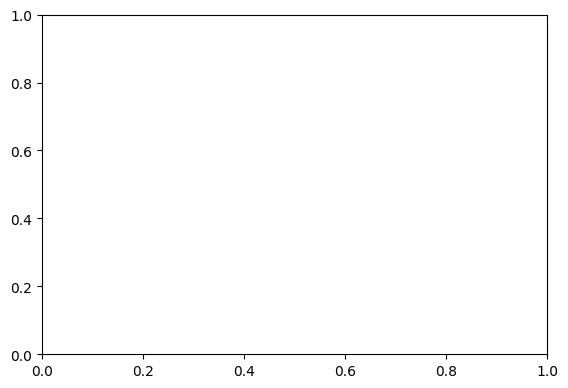

In [ ]:
for j in range(bus//3):
    plt.figure(figsize = (30, 15))

    for p in range(n):
        plt.subplot(3, 4, j+1)
        plt.plot(range(5, 25), mae_list[(bus//3)*p + j][1][1][5:25], label = '{} - model'.format(p+1))
    
    plt.title('{} - bus'.format((j+1)*3))
    plt.legend()
    plt.show()
# plt.plot(mae_list[2][1][1])

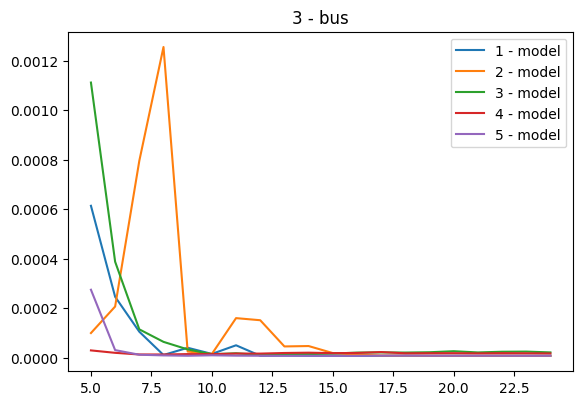

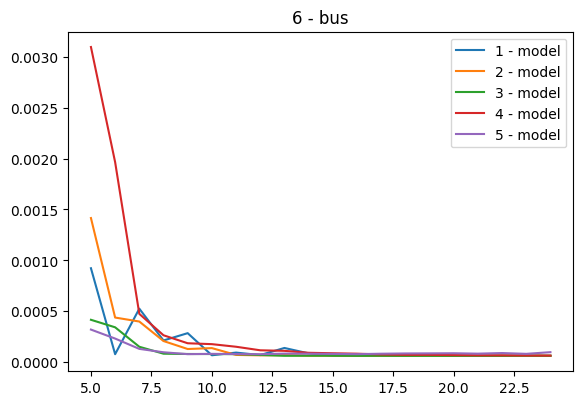

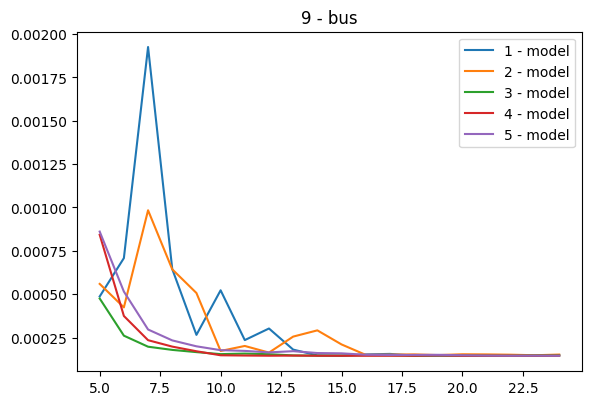

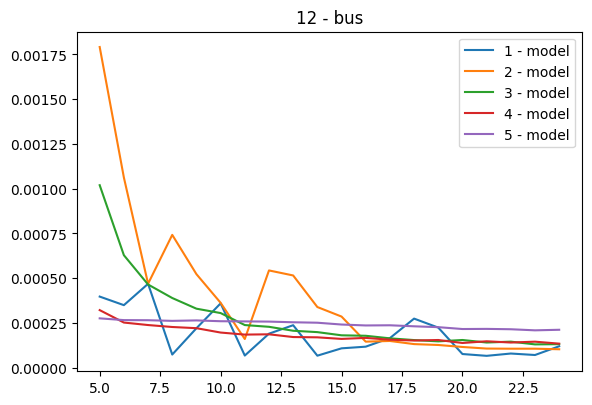

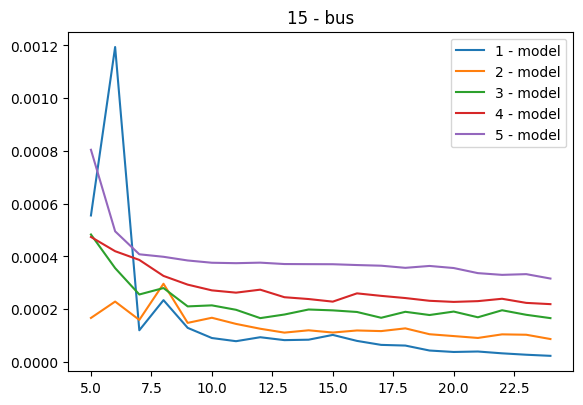

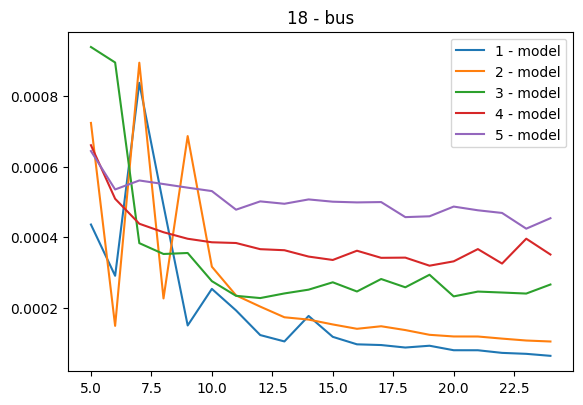

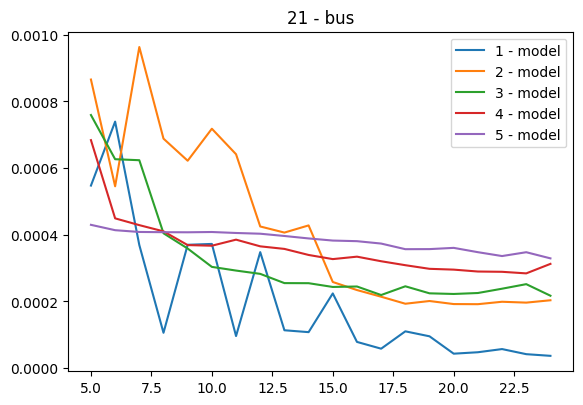

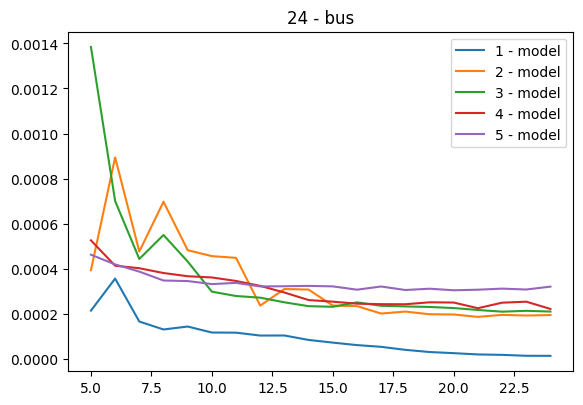

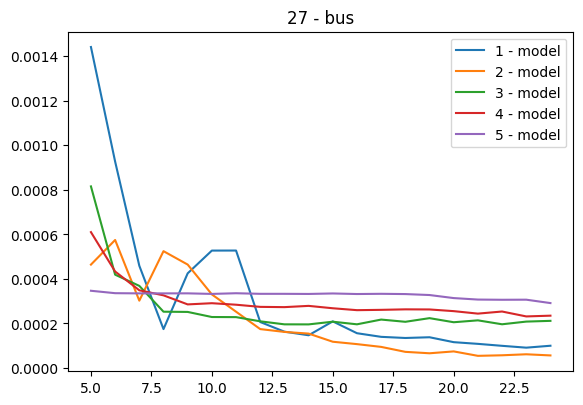

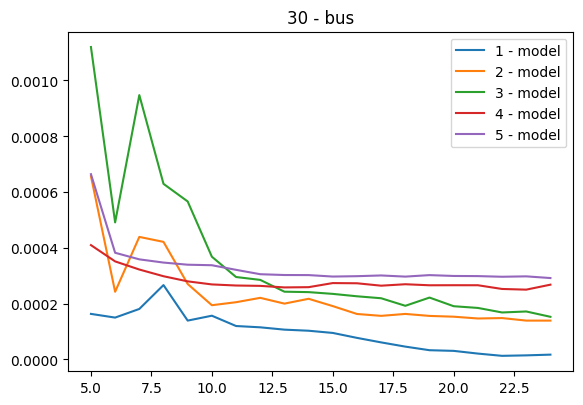

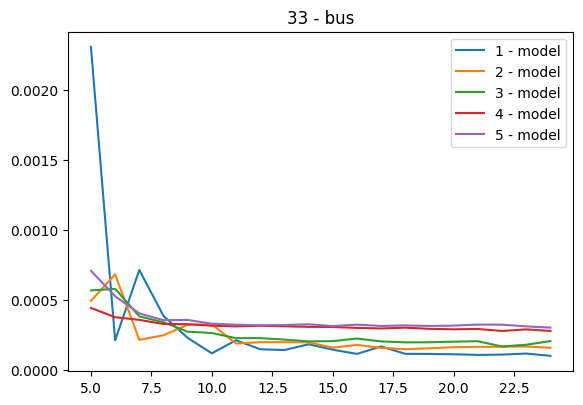

In [ ]:
for j in range(bus//3):
    plt.figure(figsize = (30, 15))

    for p in range(n):
        plt.subplot(3, 4, j+1)
        plt.plot(range(5, 25), mae_list[(bus//3)*p + j][1][1][5:25], label = '{} - model'.format(p+1))
    
    plt.title('{} - bus'.format((j+1)*3))
    plt.legend()
    plt.show()
# plt.plot(mae_list[2][1][1])

IndexError: list index out of range

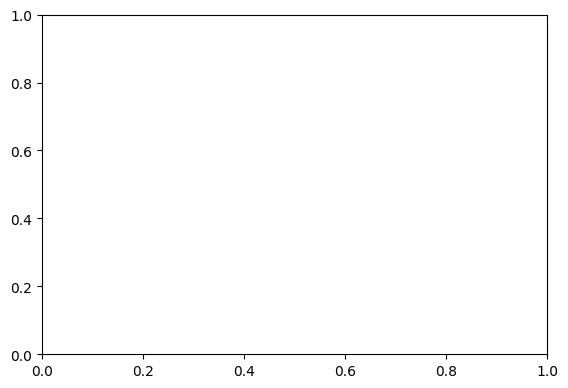

In [ ]:
for j in range(bus//3):
    plt.figure(figsize = (30, 15))

    for p in range(n):
        plt.subplot(3, 4, j+1)
        plt.plot(range(25, 50), mae_list[(bus//3)*p + j][1][1][25:50], label = '{} - model'.format(p+1))
    
    plt.title('{} - bus'.format((j+1)*3))
    plt.legend()
    plt.show()
# plt.plot(mae_list[2][1][1])

In [ ]:
from tqdm import tqdm

mae_list = []

n = 5
bus = 33
interval = 6
epochs = 50
verbose = 0


# n의 의미는 build model 당시 층의 개수, 복잡도를 의미

for i in tqdm(range(1, n + 1)):
    # for i in range(3, 33 + 1, 6):
# for j in range(3, bus + 1, 3):
    my_powerflow = Powerflow(3)
    my_powerflow.load_data()
    my_powerflow.prepare_data()
    my_powerflow.build_model(n = i, check = True)


        # mae_list.append([i, V, D])

  0%|          | 0/5 [00:00<?, ?it/s]

now model has 3 bus
Model: "sequential_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1356 (Dense)          (None, 64)                320       
                                                                 
 dropout_803 (Dropout)       (None, 64)                0         
                                                                 
 dense_1357 (Dense)          (None, 32)                2080      
                                                                 
 dropout_804 (Dropout)       (None, 32)                0         
                                                                 
 dense_1358 (Dense)          (None, 6)                 198       
                                                                 
 dense_1359 (Dense)          (None, 2)                 14        
                                                                 
Total params: 2,612
Trainable pa

 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

now model has 3 bus
Model: "sequential_261"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1360 (Dense)          (None, 128)               640       
                                                                 
 dropout_805 (Dropout)       (None, 128)               0         
                                                                 
 dense_1361 (Dense)          (None, 64)                8256      
                                                                 
 dropout_806 (Dropout)       (None, 64)                0         
                                                                 
 dense_1362 (Dense)          (None, 32)                2080      
                                                                 
 dropout_807 (Dropout)       (None, 32)                0         
                                                                 
 dense_1363 (Dense)          (No

 40%|████      | 2/5 [00:01<00:02,  1.39it/s]

now model has 3 bus
Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1365 (Dense)          (None, 256)               1280      
                                                                 
 dropout_808 (Dropout)       (None, 256)               0         
                                                                 
 dense_1366 (Dense)          (None, 128)               32896     
                                                                 
 dropout_809 (Dropout)       (None, 128)               0         
                                                                 
 dense_1367 (Dense)          (None, 64)                8256      
                                                                 
 dropout_810 (Dropout)       (None, 64)                0         
                                                                 
 dense_1368 (Dense)          (No

 60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

now model has 3 bus
Model: "sequential_263"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1371 (Dense)          (None, 512)               2560      
                                                                 
 dropout_812 (Dropout)       (None, 512)               0         
                                                                 
 dense_1372 (Dense)          (None, 256)               131328    
                                                                 
 dropout_813 (Dropout)       (None, 256)               0         
                                                                 
 dense_1373 (Dense)          (None, 128)               32896     
                                                                 
 dropout_814 (Dropout)       (None, 128)               0         
                                                                 
 dense_1374 (Dense)          (No

 80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

now model has 3 bus
Model: "sequential_264"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1378 (Dense)          (None, 1024)              5120      
                                                                 
 dropout_817 (Dropout)       (None, 1024)              0         
                                                                 
 dense_1379 (Dense)          (None, 512)               524800    
                                                                 
 dropout_818 (Dropout)       (None, 512)               0         
                                                                 
 dense_1380 (Dense)          (None, 256)               131328    
                                                                 
 dropout_819 (Dropout)       (None, 256)               0         
                                                                 
 dense_1381 (Dense)          (No

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [ ]:
bus//2

3

In [ ]:
n

5

In [ ]:
mae_list[0][1][0]

[0.2020777016878128,
 0.020297234877943993,
 0.014677292667329311,
 0.011809390969574451,
 0.009676639921963215,
 0.008046211674809456,
 0.006128290668129921,
 0.0043222736567258835,
 0.00285509810782969,
 0.0019351101946085691,
 0.0011230321833863854,
 0.0006823759176768363,
 0.00041292727109976113,
 0.0002384992258157581,
 0.00014875808847136796,
 9.767938172444701e-05,
 6.508097430923954e-05,
 4.5958040573168546e-05,
 3.398089756956324e-05,
 2.61660370597383e-05,
 2.1402855054475367e-05,
 1.8058748537441716e-05,
 1.5744912161608227e-05,
 1.3970736290502828e-05,
 1.2138038073317148e-05,
 1.1425143384258263e-05,
 1.0626366929500364e-05,
 1.0151527931157034e-05,
 9.84577854978852e-06,
 9.217978913511615e-06,
 9.069617590284906e-06,
 8.685058674018364e-06,
 8.59260035213083e-06,
 8.481443728669547e-06,
 8.293122846225742e-06,
 8.260029972007032e-06,
 8.039942258619703e-06,
 7.974608706717845e-06,
 7.887951142038219e-06,
 7.81867220212007e-06,
 7.799572813382838e-06,
 7.985092452145182e-

In [ ]:
len(v_mse_v)

In [ ]:

for j in range(10, epochs + 1, 10):
    for i in range(1, n + 1):
        t_mae_v = np.array([mae_list[n][1][0] for i in range(len(mae_list))])
        v_mae_v = np.array([mae_list[n][1][1] for i in range(len(mae_list))])

        t_mae_d = np.array([mae_list[n][2][0] for i in range(len(mae_list))])
        v_mae_d = np.array([mae_list[n][2][0] for i in range(len(mae_list))])

        plt.figure(figsize=(40,10))



        length = len(t_mae_v)
        plt.subplot(1, 5, j//10)
        # plt.plot(range(3, length*3+1, 3), t_mae_v[:, j-1]*100)
        plt.plot(range(3, length*3+1, 3), v_mae_v[:, j-1]*100)
        plt.title('{} model and {} epoch'.format(i, j))

    plt.show()

In [ ]:
v_mae_v.shape

(10, 50)

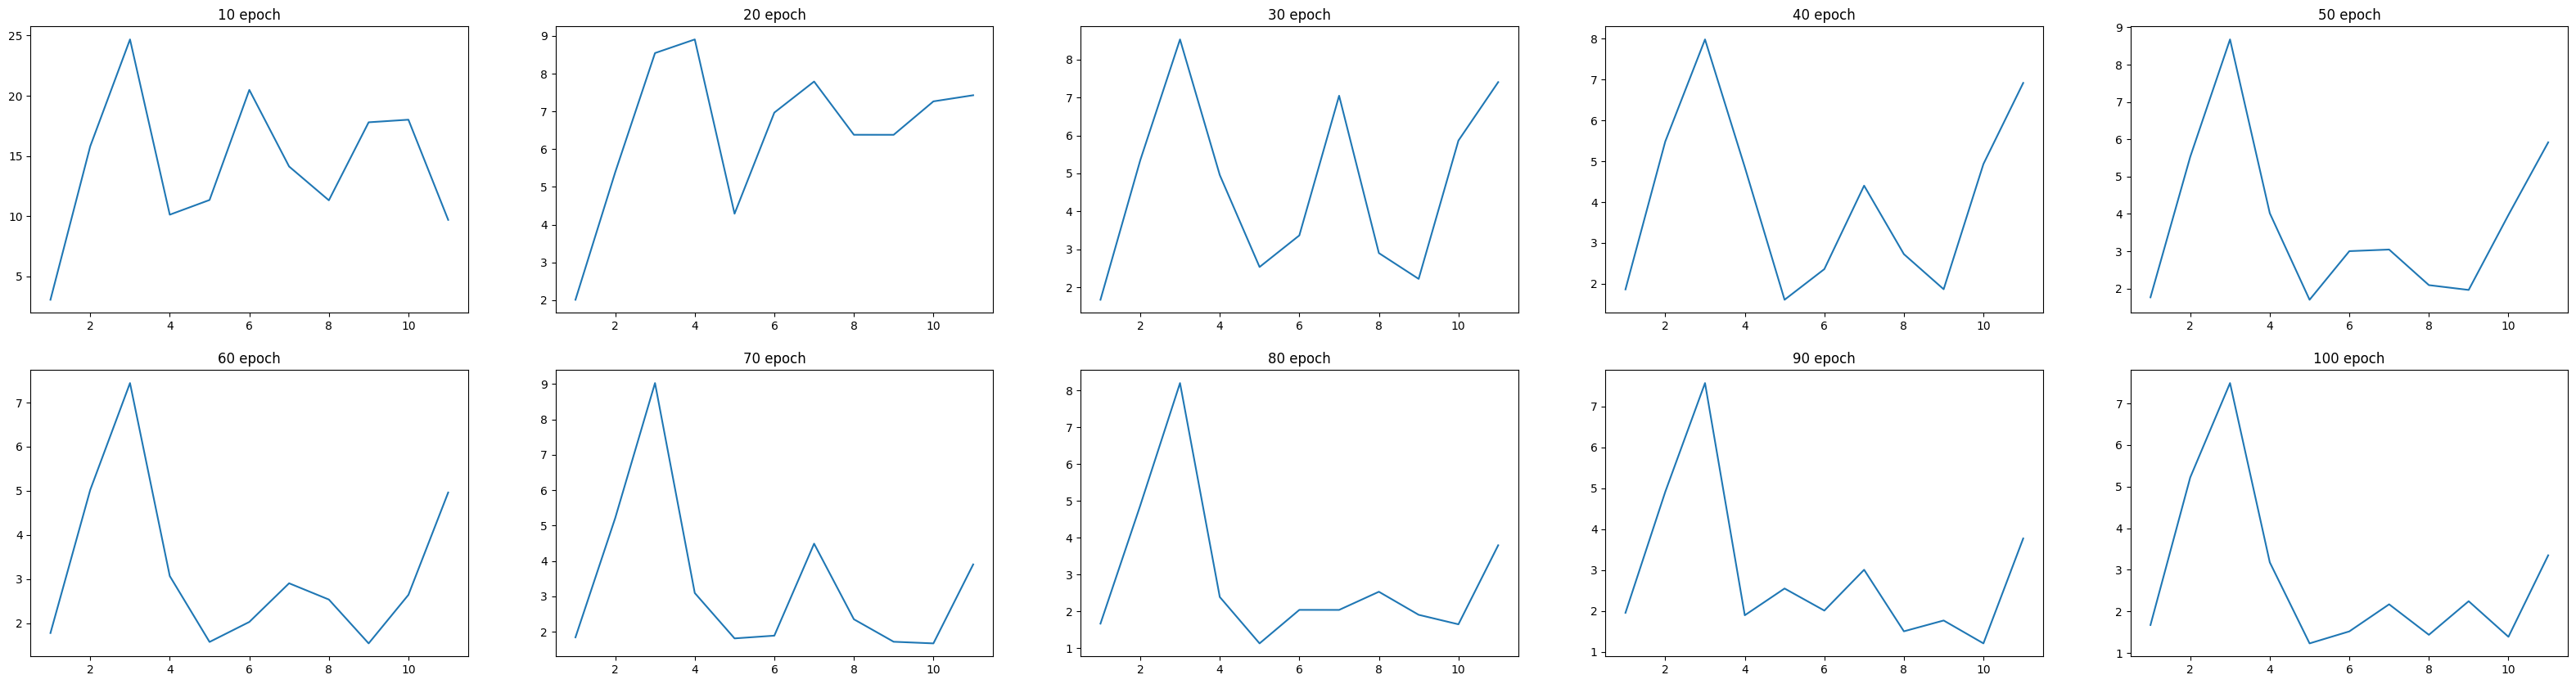

In [ ]:
mae_v = np.array([mae_list[i][0] for i in range(len(mae_list))])
mae_d = np.array([mae_list[i][1] for i in range(len(mae_list))])

plt.figure(figsize=(40,10))

for i in range(10, 101, 10):

    plt.subplot(2, 5, i//10)
    plt.plot(range(1, len(mae_v)+1), mae_v[:, i-1]*1000)
    plt.title('{} epoch'.format(i))

plt.show()

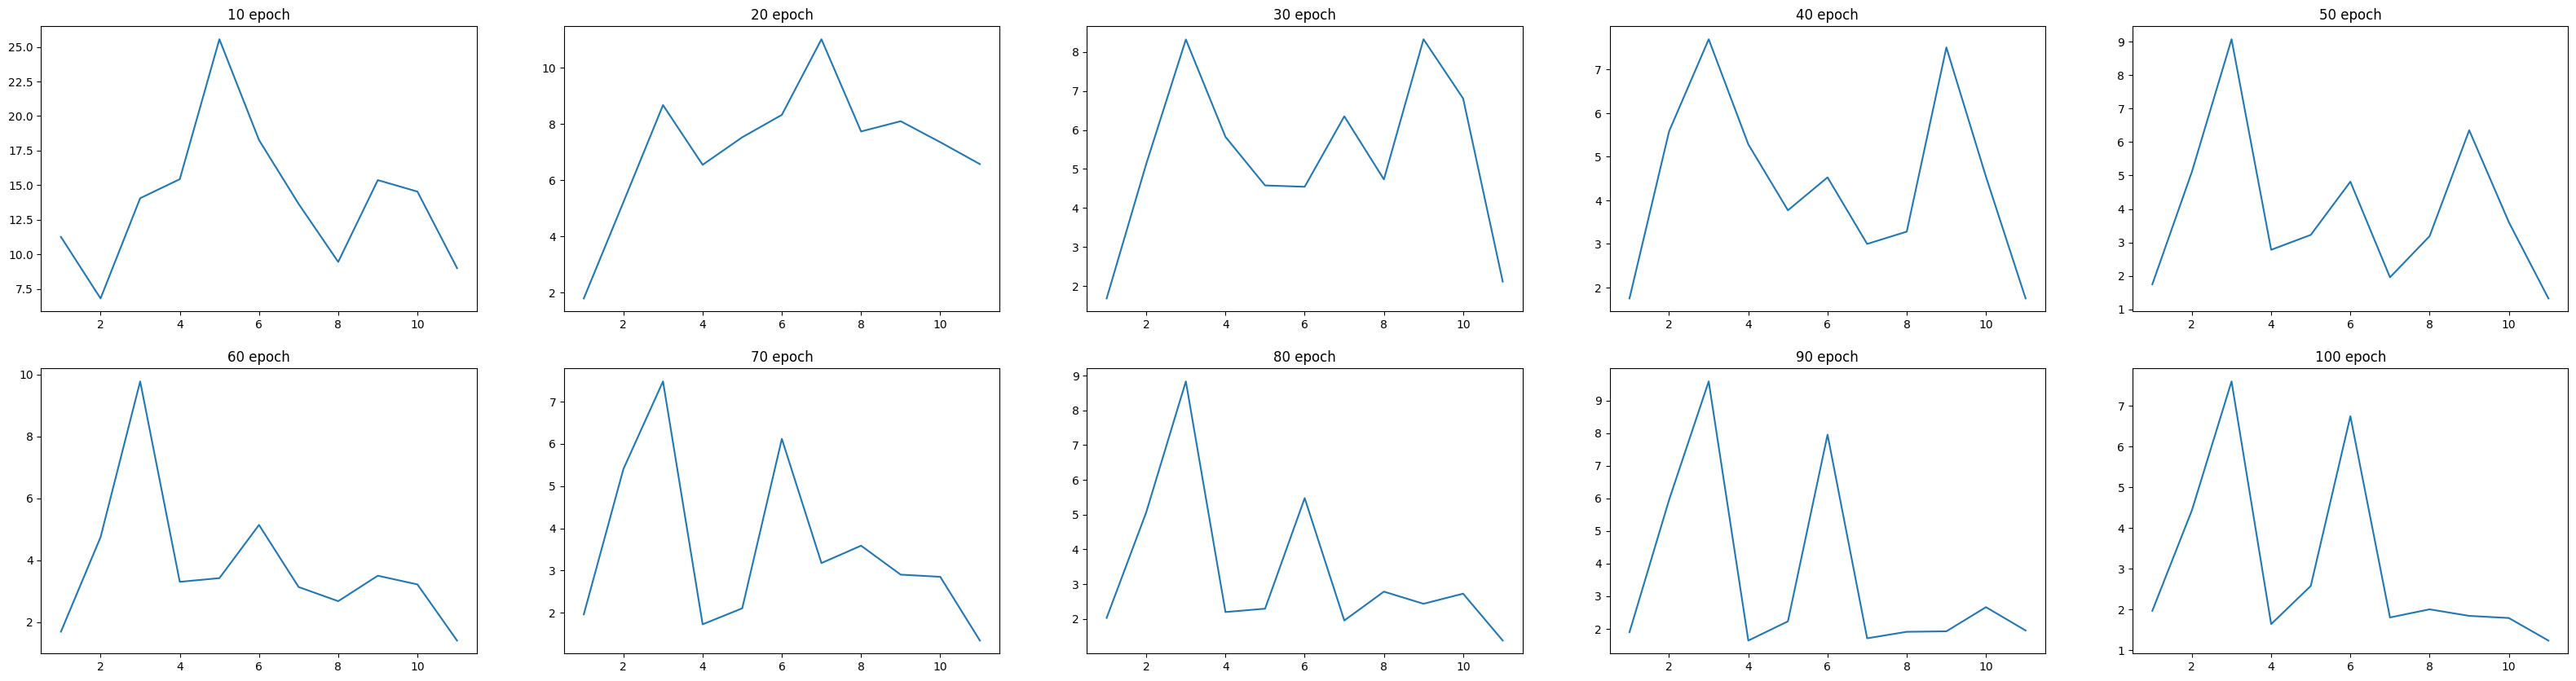

In [ ]:
plt.figure(figsize=(40,10))

for i in range(10, 101, 10):

    plt.subplot(2, 5, i//10)
    plt.plot(range(1, len(mae_d)+1), mae_d[:, i-1]*1000)
    plt.title('{} epoch'.format(i))

plt.show()

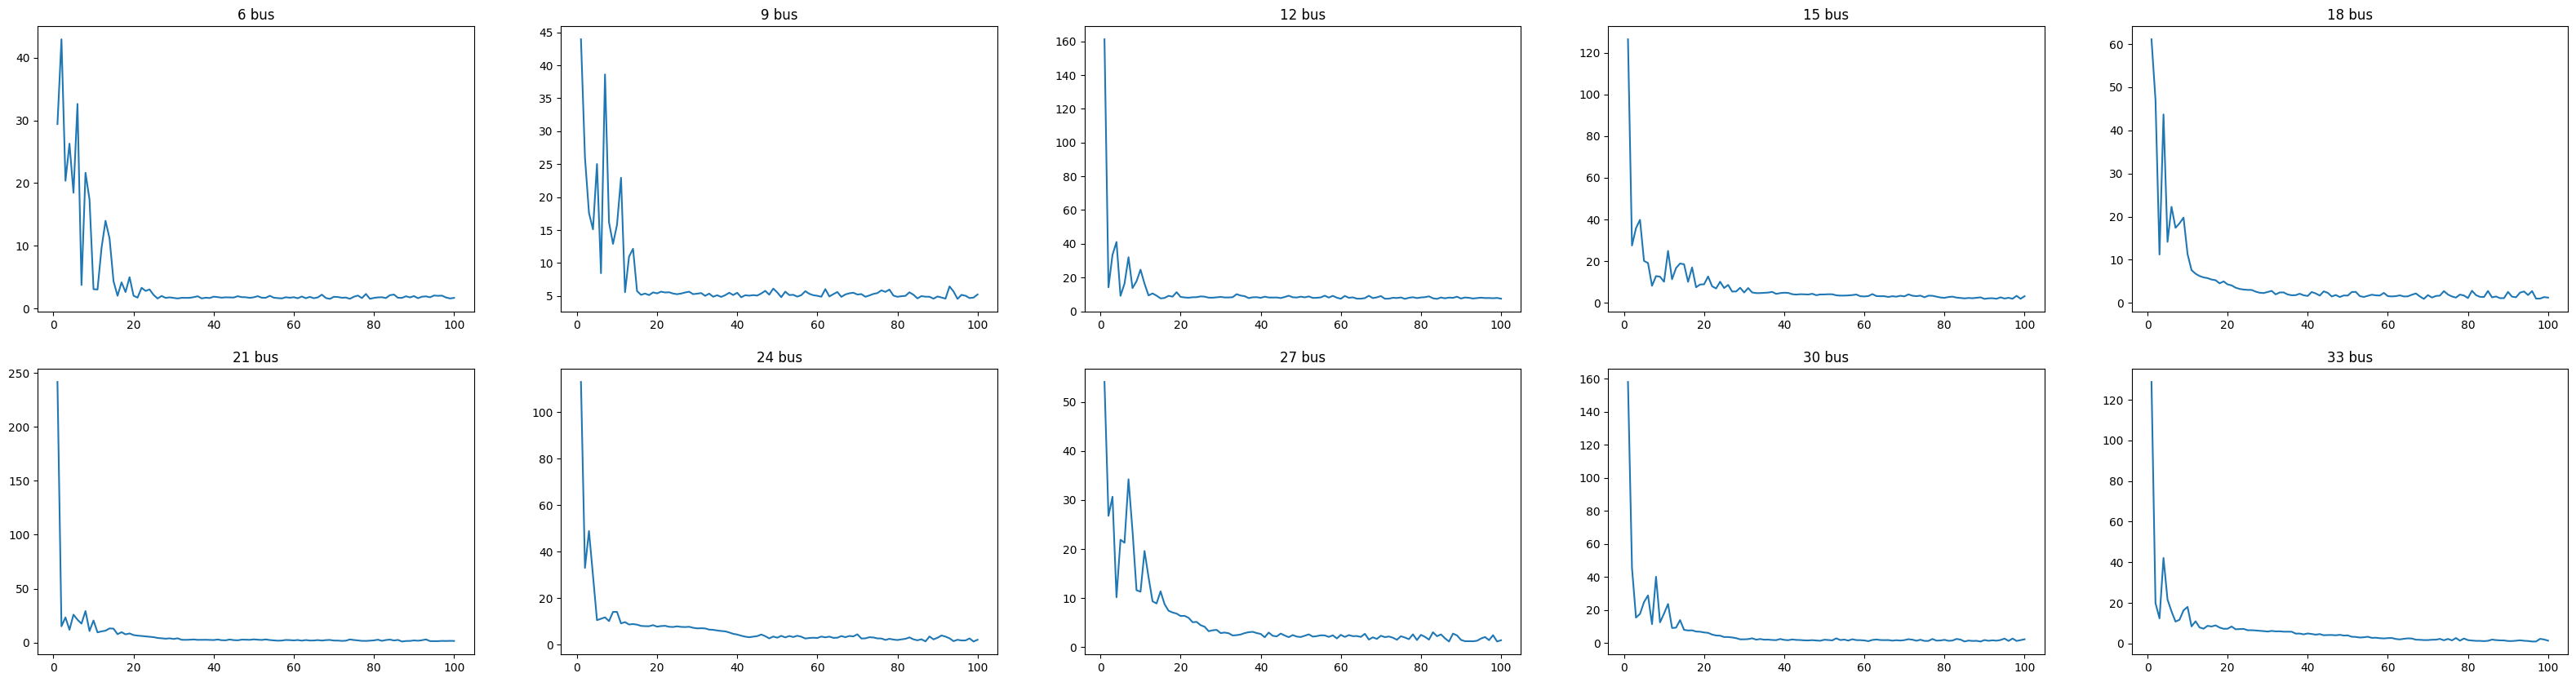

In [ ]:
plt.figure(figsize=(40,10))

for i in range(1, 11):

    plt.subplot(2, 5, i)
    plt.plot(range(1, len(mae_v[0])+1), mae_v[i-1, :]*1000)
    plt.title('{} bus'.format(i*3+3))

plt.show()

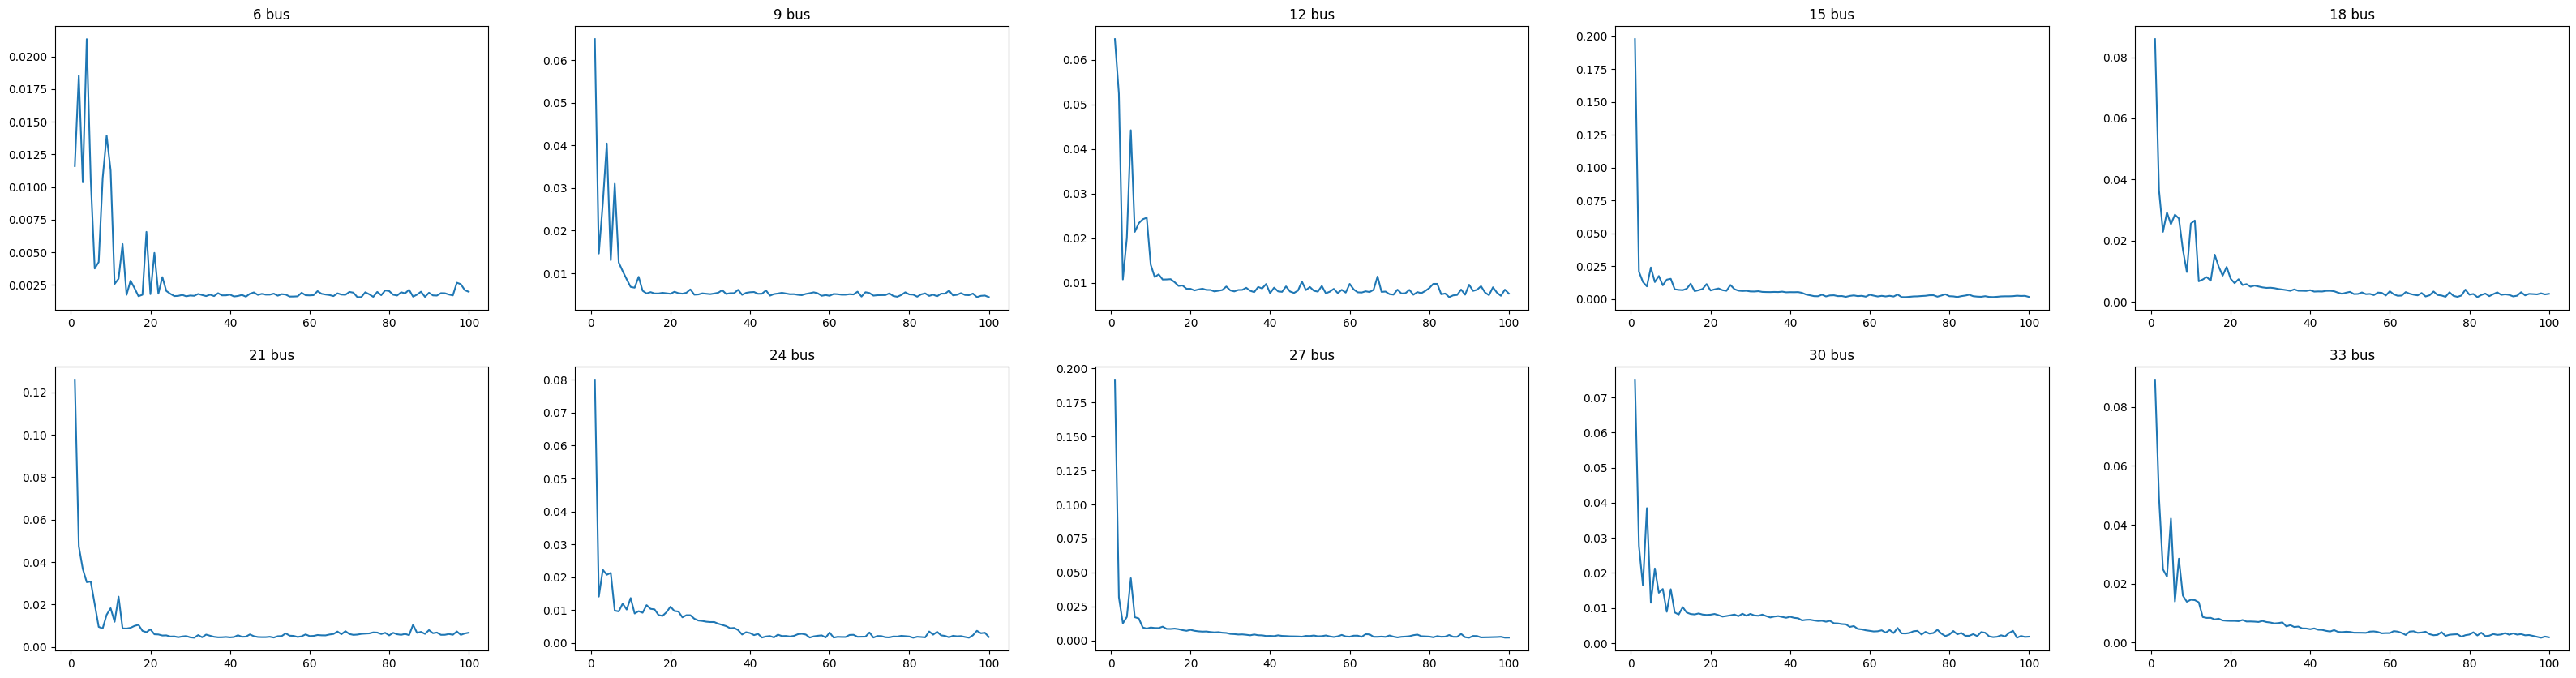

In [ ]:
plt.figure(figsize=(40,10))

for i in range(1, 11):

    plt.subplot(2, 5, i)
    plt.plot(range(1, len(mae_d[0])+1), mae_d[i-1, :])
    plt.title('{} bus'.format(i*3+3))

plt.show()

In [ ]:
len(mae_v[0,:])

100

In [ ]:
V3 = fit_model(N, 1)
D3 = fit_model(N, 2)

plot_mae(V3)
plot_mae(D3)

In [ ]:
V3 = fit_model(N, 1)
D3 = fit_model(N, 2)

plot_mae(V3)
plot_mae(D3)

In [ ]:
V3 = fit_model(N, 1)
D3 = fit_model(N, 2)

plot_mae(V3)
plot_mae(D3)